In [3]:
# Core data handling & ML
import pandas as pd
import numpy as np
import sklearn               # for model pipelines, metrics, preprocessing
import xgboost               # for XGBoost classifier
import swifter               # for accelerating DataFrame.apply

# Text processing & tokenization
import re                    # regex-based counts
import nltk                  # tokenization, stopword lists if needed
import spacy                 # POS tagging, NER
from spacy.lang.en import English
from langdetect import detect
import aiohttp               # async HTTP if needed for scraping
import nest_asyncio          # for running async code in notebooks

# Psycholinguistic & lexicon-based features
from empath import Empath    # LIWC-style category counts
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import textstat              # readability metrics

# Sentiment & subjectivity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Readability indices
import textstat     

# Regex-based punctuation & case features
import re

# Model interpretability
import shap

# Progress bars & visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick            # model diagnostics
import wordcloud

# Notebook utilities
%load_ext autoreload
%autoreload 2


d:\Anaconda\envs\DeceptionNLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import swifter
import os

In [5]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

This notebook is containing the feature analysis, and feature engineering of the dataset.  

### Loading the dataset. 

In [6]:
df = pd.read_csv('../Dataset/WELFake_Dataset.csv')

In [7]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [8]:
df.head()

,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last n...",1
2,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0
3,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1
4,about time! christian group sues amazon and sp...,all we can say on this one is it s about time ...,1


### Comparision of average word lengths

Pandas Apply: 100%|██████████| 70793/70793 [00:27<00:00, 2531.76it/s]


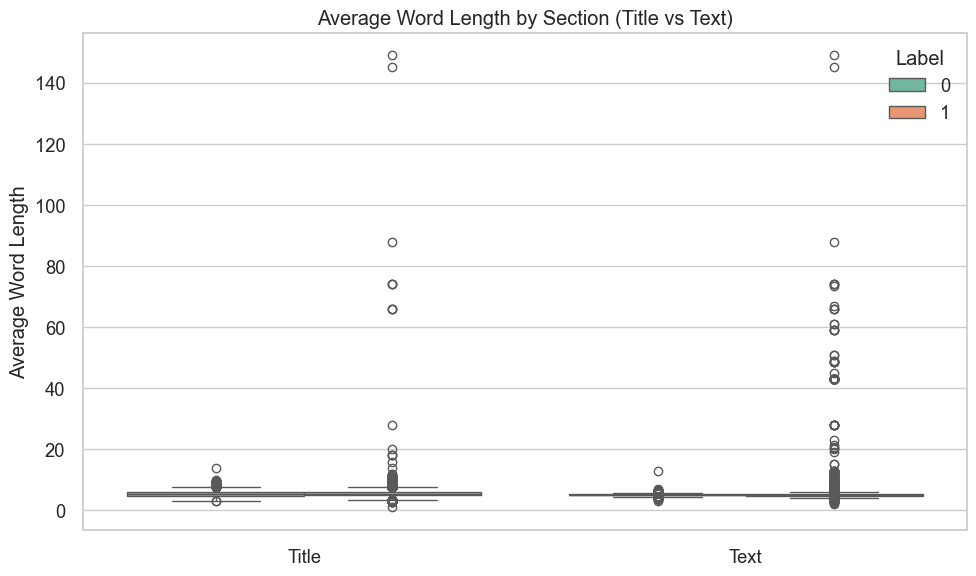

In [20]:
df["title_avg_word_length"] = df["title"].swifter.apply(lambda x: sum(len(word) for word in x.split()) / max(len(x.split()), 1))
df["text_avg_word_length"] = df["text"].swifter.apply(lambda x: sum(len(word) for word in x.split()) / max(len(x.split()), 1))

# Melt the DataFrame for seaborn
melted_df = pd.melt(df,
                    id_vars="label",
                    value_vars=["title_avg_word_length", "text_avg_word_length"],
                    var_name="Section",
                    value_name="AvgWordLength")

# Rename sections for clarity
melted_df["Section"] = melted_df["Section"].map({
    "title_avg_word_length": "Title",
    "text_avg_word_length": "Text"
})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Section", y="AvgWordLength", hue="label", data=melted_df, palette="Set2")
plt.title("Average Word Length by Section (Title vs Text)")
plt.ylabel("Average Word Length")
plt.xlabel("")
plt.legend(title="Label")

# Save the plot
output_dir = "../visualizations"
os.makedirs(output_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "avg_word_length_boxplot_by_label.png"), dpi=300, bbox_inches="tight")
plt.show()


In [22]:
df.drop(columns = ['avg_word_len_title', 'avg_word_len_text'], inplace = True)

In [23]:
df.head()

,title,text,label,title_avg_word_length,text_avg_word_length
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,6.277778,4.717566
1,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last n...",1,6.666667,5.264706
2,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0,5.625000,5.041635
3,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,5.000000,4.823708
4,about time! christian group sues amazon and sp...,all we can say on this one is it s about time ...,1,5.076923,5.229508


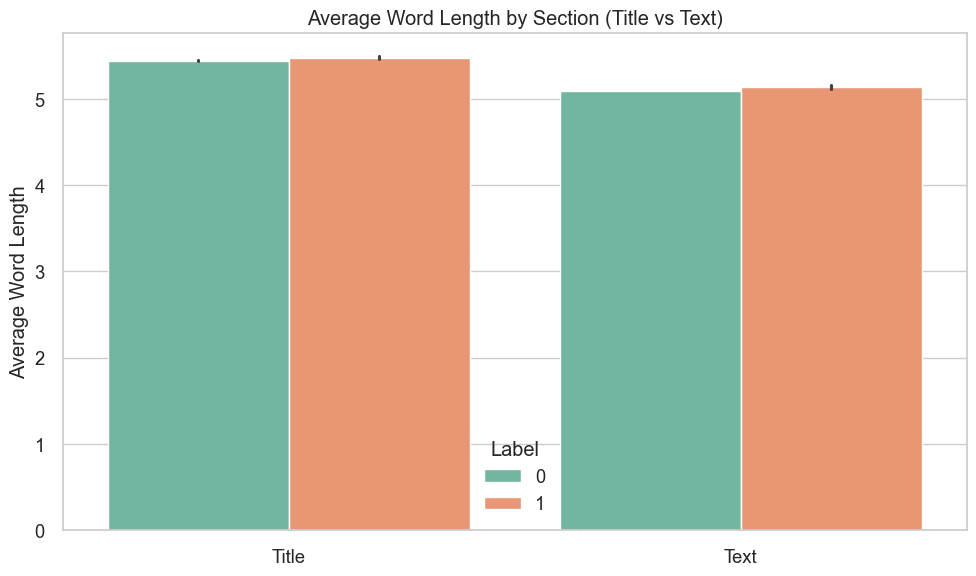

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Section", y="AvgWordLength", hue="label", data=melted_df, palette="Set2")
plt.title("Average Word Length by Section (Title vs Text)")
plt.ylabel("Average Word Length")
plt.xlabel("")
plt.legend(title="Label")

# Save the plot
output_dir = "../visualizations"
os.makedirs(output_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "avg_word_length_barplot_by_label.png"), dpi=300, bbox_inches="tight")
plt.show()


In [27]:
import nltk

In [9]:
from featurederivator import process_and_save_in_batches

In [16]:
process_and_save_in_batches(df, batch_size=5000)

import glob

title_features = pd.concat(
    [pd.read_csv(f) for f in sorted(glob.glob("processed_title_chunks/title_features_batch_*.csv"))],
    ignore_index=True
)



Processing batch 1/15 — Rows 0 to 5000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 256900.03it/s]


Saved: processed_title_chunks\title_features_batch_1.csv
Processing batch 2/15 — Rows 5000 to 10000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 206925.84it/s]


Saved: processed_title_chunks\title_features_batch_2.csv
Processing batch 3/15 — Rows 10000 to 15000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 187787.28it/s]


Saved: processed_title_chunks\title_features_batch_3.csv
Processing batch 4/15 — Rows 15000 to 20000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 314944.43it/s]


Saved: processed_title_chunks\title_features_batch_4.csv
Processing batch 5/15 — Rows 20000 to 25000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 323066.21it/s]


Saved: processed_title_chunks\title_features_batch_5.csv
Processing batch 6/15 — Rows 25000 to 30000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 298331.63it/s]


Saved: processed_title_chunks\title_features_batch_6.csv
Processing batch 7/15 — Rows 30000 to 35000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 520243.11it/s]


Saved: processed_title_chunks\title_features_batch_7.csv
Processing batch 8/15 — Rows 35000 to 40000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 502384.06it/s]


Saved: processed_title_chunks\title_features_batch_8.csv
Processing batch 9/15 — Rows 40000 to 45000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 323609.60it/s]


Saved: processed_title_chunks\title_features_batch_9.csv
Processing batch 10/15 — Rows 45000 to 50000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 482503.22it/s]


Saved: processed_title_chunks\title_features_batch_10.csv
Processing batch 11/15 — Rows 50000 to 55000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 485002.78it/s]


Saved: processed_title_chunks\title_features_batch_11.csv
Processing batch 12/15 — Rows 55000 to 60000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 359273.62it/s]


Saved: processed_title_chunks\title_features_batch_12.csv
Processing batch 13/15 — Rows 60000 to 65000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 443353.77it/s]


Saved: processed_title_chunks\title_features_batch_13.csv
Processing batch 14/15 — Rows 65000 to 70000


Pandas Apply: 100%|██████████| 5000/5000 [00:00<00:00, 459227.01it/s]


Saved: processed_title_chunks\title_features_batch_14.csv
Processing batch 15/15 — Rows 70000 to 70793


Pandas Apply: 100%|██████████| 793/793 [00:00<00:00, 413743.38it/s]


Saved: processed_title_chunks\title_features_batch_15.csv


In [17]:
title_features.head()

,title,text,label,title_word_count,title_allcaps_ratio,title_exclaim_count,title_question_count,title_quote_count,title_pronoun_ratio,title_fk_grade,title_gunning_fog,title_negemo,title_posemo
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,18,0.0,0,0,0,0.000000,12.407778,16.088889,0.000000,0.0
1,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last n...",1,18,0.0,1,0,0,0.038462,15.030000,18.311111,0.000000,0.0
2,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0,16,0.0,0,0,0,0.000000,12.775000,13.900000,0.000000,0.0
3,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,16,0.0,0,0,0,0.052632,10.713333,11.333333,0.000000,0.0
4,about time! christian group sues amazon and sp...,all we can say on this one is it s about time ...,1,13,0.0,1,0,0,0.000000,7.633846,11.353846,0.076923,0.0


In [18]:
df.shape

(70793, 3)

In [19]:
title_features.shape

(70793, 13)

In [20]:
title_features.drop(columns = ['title', 'text', 'label'], inplace = True)

In [23]:
title_features.to_csv('../Dataset/title_features.csv')